<a href="https://colab.research.google.com/github/dbckz/crossing-the-line/blob/master/notebooks/processing_full_perspective_world_cup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import pandas as pd
import ast
import os
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm
from google.colab import drive
import plotly.graph_objects as go

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set up paths
root_path = "/content/drive/MyDrive/University/Dissertation/world_cup_data"
graph_path = root_path + "/graphs"

day_paths = day_paths = [
        "/1",
        "/2",
        "/291122",
        "/301122",
        "/011222",
        "/021222",
        "/031222",
        "/041222",
        "/051222",
        "/061222",
        "/071222",
        "/081222",
        "/091222",
        "/101222",
        "/111222",
        "/121222",
        "/131222",
        "/141222"
    ]

In [4]:
# Create directory to store visualisations
try:
    os.mkdir(graph_path)
except OSError as error:
    print(error)

[Errno 17] File exists: '/content/drive/MyDrive/University/Dissertation/world_cup_data/graphs'


In [6]:
# Load data
in_tweets = pd.DataFrame()
persp = pd.DataFrame()
emojis = pd.DataFrame()
for path in day_paths:
    directory = root_path + path
    tweets_csv = directory + "/tweets.csv"
    persp_csv = directory + "/perspective_processed_tweets.csv"
    emojis_csv = directory + "/emoji.csv"

    print(f"Loading CSVs for directory {path}...")
    in_tweets = pd.concat([in_tweets, 
                           pd.read_csv(tweets_csv,
                                       usecols = [
                                                  'created_at',
                                                  'tweet_id',
                                                  'tweet_text',
                                                  'accounts_mentioned'
                                       ],
                                       dtype = {
                                          # 'created_at':
                                          'tweet_id': np.int64,
                                          'tweet_text': str,
                                          'accounts_mentioned': object
                                       },
                                       parse_dates=['created_at'])])

    persp = pd.concat([persp, pd.read_csv(persp_csv,
                                          usecols = [
                                                      'tweet_id',
                                                      'identity_attack_score',
                                                      'threat_score',
                                                      'severe_toxicity_score',
                                                      'insult_score'
                                                      
                                          ],
                                          dtype = {
                                              'tweet_id': np.int64,
                                              'identity_attack_score': float,
                                              'threat_score': float,
                                              'severe_toxicity_score': float,
                                              'insult_score': float
                                          })])

# Dedup
original_tweets_length = len(in_tweets)
original_persp_length = len(persp)
in_tweets.drop_duplicates(subset=['tweet_id'], inplace=True)
persp.drop_duplicates(subset=['tweet_id'], inplace=True)
print(f"Size of tweets dataframe: {len(in_tweets)}, having dropped {original_tweets_length - len(in_tweets)} duplicate rows")
print(f"Size of perspective dataframe: {len(persp)}, having dropped {original_persp_length - len(persp)} duplicate rows")


Loading CSVs for directory /1...
Loading CSVs for directory /2...
Loading CSVs for directory /291122...
Loading CSVs for directory /301122...
Loading CSVs for directory /011222...
Loading CSVs for directory /021222...
Loading CSVs for directory /031222...
Loading CSVs for directory /041222...
Loading CSVs for directory /051222...
Loading CSVs for directory /061222...
Loading CSVs for directory /071222...
Loading CSVs for directory /081222...
Loading CSVs for directory /091222...
Loading CSVs for directory /101222...
Loading CSVs for directory /111222...
Loading CSVs for directory /121222...
Loading CSVs for directory /131222...
Loading CSVs for directory /141222...
Size of tweets dataframe: 327827, having dropped 7804 duplicate rows
Size of perspective dataframe: 327827, having dropped 7822 duplicate rows


In [7]:
# Up the pandas display limits so printed dataframes aren't so truncated
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_info_rows', 100)
pd.set_option('display.max_info_columns', 100)
pd.set_option('display.precision', 9)

In [8]:
# Join tables + drop old ones!
joined_df = pd.merge(in_tweets, persp, how='inner', on='tweet_id')
del persp
del in_tweets
len(joined_df)

327827

In [9]:
# joined_df = joined_df[(joined_df['created_at'] > '2021-06-19 08:10:18+00:00') & (joined_df['created_at'] < '2021-07-17 00:00:00+00:00')]
len(joined_df)

327827

# Analysis

In [10]:
print(f"Number of tweets that Perspective could not process: {len(joined_df[joined_df['identity_attack_score'] == -1.0])}") # might need to do this later...

Number of tweets that Perspective could not process: 18322


In [12]:
# Extract players
list_of_players = ["JPickford1", "kylewalker2", "LukeShaw23", "_DeclanRice",
                   "HarryMaguire93", "JackGrealish", "JHenderson", "HKane", 
                   "sterling7", "MarcusRashford", "trippier2",
                   "PhilFoden", "ben6white", "BukayoSaka87", "BellinghamJude", 
                   "Popey1992", "AaronRamsdale98", "CallumWilson", "TrentAA", 
                   "Madders10", "ericdier", "Kalvinphillips"]


for player in list_of_players:
    print(f"Extracting {player}...")
    joined_df[player] = joined_df['accounts_mentioned'].str.contains(f"'username': '{player}'").astype(bool)



Extracting JPickford1...
Extracting kylewalker2...
Extracting LukeShaw23...
Extracting _DeclanRice...
Extracting HarryMaguire93...
Extracting JackGrealish...
Extracting JHenderson...
Extracting HKane...
Extracting sterling7...
Extracting MarcusRashford...
Extracting trippier2...
Extracting PhilFoden...
Extracting ben6white...
Extracting BukayoSaka87...
Extracting BellinghamJude...
Extracting Popey1992...
Extracting AaronRamsdale98...
Extracting CallumWilson...
Extracting TrentAA...
Extracting Madders10...
Extracting ericdier...
Extracting Kalvinphillips...


In [13]:
joined_df = joined_df[
    (joined_df["JPickford1"]) |
    (joined_df["kylewalker2"]) |
    (joined_df["LukeShaw23"]) |
    (joined_df["_DeclanRice"]) |
    (joined_df["HarryMaguire93"]) |
    (joined_df["JackGrealish"]) |
    (joined_df["JHenderson"]) |
    (joined_df["HKane"]) |
    (joined_df["sterling7"]) |
    (joined_df["MarcusRashford"]) |
    (joined_df["trippier2"]) |
    (joined_df["Kalvinphillips"]) |
    (joined_df["PhilFoden"]) |
    (joined_df["ben6white"]) |
    (joined_df["Popey1992"]) |
    (joined_df["AaronRamsdale98"]) |
    (joined_df["CallumWilson"]) |
    (joined_df["TrentAA"]) |
    (joined_df["Madders10"]) |
    (joined_df["ericdier"]) |
    (joined_df["BukayoSaka87"]) |
    (joined_df["BellinghamJude"])
    ]

In [14]:
print(len(joined_df))

302051


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f45a7cc4670>]],
      dtype=object)

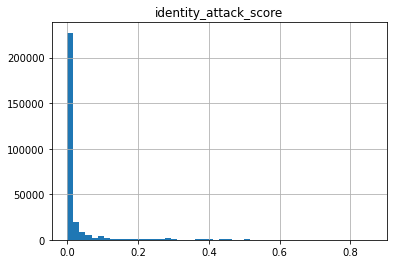

In [15]:
joined_df[joined_df['identity_attack_score'] != -1.0].hist(column = 'identity_attack_score', bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f45a7c2fa00>]],
      dtype=object)

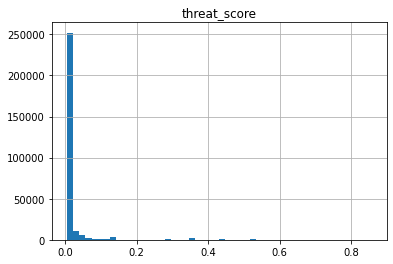

In [16]:
joined_df[joined_df['threat_score'] != -1.0].hist(column = 'threat_score', bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f45a78b5d60>]],
      dtype=object)

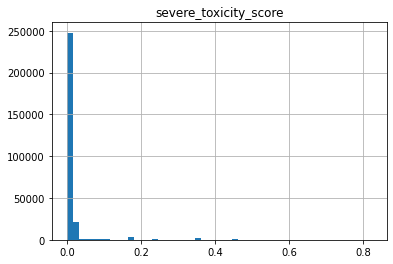

In [17]:
joined_df[joined_df['severe_toxicity_score'] != -1.0].hist(column = 'severe_toxicity_score', bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f45a780e0a0>]],
      dtype=object)

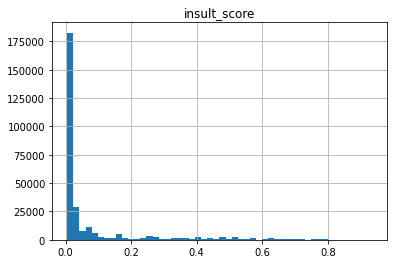

In [18]:
joined_df[joined_df['insult_score'] != -1.0].hist(column = 'insult_score', bins=50)

In [19]:
len_total = len(joined_df)
threshold = 0.5

tmp = pd.merge(joined_df[joined_df['identity_attack_score'] > 0.9], joined_df[joined_df['threat_score'] > 0.9], how='outer', on='tweet_id')
tmp = pd.merge(tmp, joined_df[joined_df['severe_toxicity_score'] > 0.9], how='outer', on='tweet_id')
# tmp = pd.merge(tmp, joined_df[joined_df['insult_score'] > 0.9], how='outer', on='tweet_id')
len_90 = len(tmp)
print(f"Tweets with scores > 0.9: {len_90}, which is {(100 * (len_90 / len_total)):.2f}% of all tweets")

tmp = pd.merge(joined_df[joined_df['identity_attack_score'] > 0.8], joined_df[joined_df['threat_score'] > 0.8], how='outer', on='tweet_id')
tmp = pd.merge(tmp, joined_df[joined_df['severe_toxicity_score'] > 0.8], how='outer', on='tweet_id')
# tmp = pd.merge(tmp, joined_df[joined_df['insult_score'] > 0.8], how='outer', on='tweet_id')
len_80 = len(tmp)
print(f"Tweets with scores > 0.8: {len_80}, which is {(100 * (len_80 / len_total)):.2f}% of all tweets")

tmp = pd.merge(joined_df[joined_df['identity_attack_score'] > 0.7], joined_df[joined_df['threat_score'] > 0.7], how='outer', on='tweet_id')
tmp = pd.merge(tmp, joined_df[joined_df['severe_toxicity_score'] > 0.7], how='outer', on='tweet_id')
# tmp = pd.merge(tmp, joined_df[joined_df['insult_score'] > 0.7], how='outer', on='tweet_id')
len_70 = len(tmp)
print(f"Tweets with scores > 0.7: {len_70}, which is {(100 * (len_70 / len_total)):.2f}% of all tweets")

tmp = pd.merge(joined_df[joined_df['identity_attack_score'] > 0.6], joined_df[joined_df['threat_score'] > 0.6], how='outer', on='tweet_id')
tmp = pd.merge(tmp, joined_df[joined_df['severe_toxicity_score'] > 0.6], how='outer', on='tweet_id')
# tmp = pd.merge(tmp, joined_df[joined_df['insult_score'] > 0.6], how='outer', on='tweet_id')
len_60 = len(tmp)
print(f"Tweets with scores > 0.6: {len_60}, which is {(100 * (len_60 / len_total)):.2f}% of all tweets")

tmp = pd.merge(joined_df[joined_df['identity_attack_score'] > 0.5], joined_df[joined_df['threat_score'] > 0.5], how='outer', on='tweet_id')
tmp = pd.merge(tmp, joined_df[joined_df['severe_toxicity_score'] > 0.5], how='outer', on='tweet_id')
# tmp = pd.merge(tmp, joined_df[joined_df['insult_score'] > 0.5], how='outer', on='tweet_id')
len_50 = len(tmp)
print(f"Tweets with scores > 0.5: {len_50}, which is {(100 * (len_50 / len_total)):.2f}% of all tweets")

joined_df['persp_over_threshold'] = (joined_df['identity_attack_score'] > threshold) | (joined_df['threat_score'] > threshold) | (joined_df['severe_toxicity_score'] > threshold)
                                                                                 
del tmp


Tweets with scores > 0.9: 0, which is 0.00% of all tweets
Tweets with scores > 0.8: 7, which is 0.00% of all tweets
Tweets with scores > 0.7: 75, which is 0.02% of all tweets
Tweets with scores > 0.6: 671, which is 0.22% of all tweets
Tweets with scores > 0.5: 2736, which is 0.91% of all tweets


In [20]:
# Maybe we don't need these cols and we can just calculate ad-hoc?
for player in list_of_players:
    joined_df[f'{player}_offensive'] = joined_df['persp_over_threshold'] & joined_df[player]

In [21]:
player_offensive_tweet_map = pd.DataFrame(columns=["username",
                                                   "tweets_received",
                                                   "offensive_tweets_received",
                                                   "percentage_offensive"
                                                   ])

i = 0
for player in list_of_players:
    off_tweets = joined_df[player + '_offensive'].sum()
    tweets = joined_df[player].sum()
    percentage = 100 * (off_tweets / tweets)
    player_offensive_tweet_map.loc[i] = player, tweets, off_tweets, percentage
    i += 1

In [22]:
name_map = {
    "JPickford1": "Jordan Pickford",
    "Popey1992": "Nick Pope",
    "kylewalker2": "Kyle Walker",
    "Kalvinphillips": "Kalvin Phillips",
    "ben6white": "Benjamin White",
    "ericdier": "Eric Dier",
    "trippier2": "Kieran Trippier",
    "TrentAA": "Trent Alexander-Arnold",
    "AaronRamsdale98": "Aaron Ramsdale",
    "JHenderson": "Jordan Henderson",
    "PhilFoden": "Phil Foden",
    "CallumWilson": "Callum Wilson",
    "sterling7": "Raheem Sterling",
    "LukeShaw23": "Luke Shaw",
    "_DeclanRice": "Declan Rice",
    "Madders10": "James Maddison",
    "BellinghamJude": "Jude Bellingham",
    "JackGrealish": "Jack Grealish",
    "HarryMaguire93": "Harry Maguire",
    "MarcusRashford": "Marcus Rashford",
    "BukayoSaka87": "Bukayo Saka",
    "HKane": "Harry Kane"
}

player_offensive_tweet_map["player"] = player_offensive_tweet_map["username"].map(name_map)


In [23]:
player_offensive_tweet_map.sort_values('tweets_received', axis=0, ascending=True, inplace=True)
offensive_tweets_all = joined_df['persp_over_threshold'].sum()
offensive_tweets_top_10 = player_offensive_tweet_map['offensive_tweets_received'].head(10).sum()
top_10_proportion = offensive_tweets_top_10 / offensive_tweets_all
print(f"Total offensive tweets: {offensive_tweets_all}")
print(f"Top 10 proportion: {top_10_proportion * 100}%")

print(player_offensive_tweet_map[['player','username', 'offensive_tweets_received']])

Total offensive tweets: 2736
Top 10 proportion: 7.419590643274853%
                    player         username offensive_tweets_received
15               Nick Pope        Popey1992                         2
20               Eric Dier         ericdier                        17
0          Jordan Pickford       JPickford1                        21
10         Kieran Trippier        trippier2                         8
21         Kalvin Phillips   Kalvinphillips                         6
16          Aaron Ramsdale  AaronRamsdale98                        20
12          Benjamin White        ben6white                        27
1              Kyle Walker      kylewalker2                        29
17           Callum Wilson     CallumWilson                        25
2                Luke Shaw       LukeShaw23                        48
18  Trent Alexander-Arnold          TrentAA                        54
8          Raheem Sterling        sterling7                       107
19          James Maddi

In [ ]:
# Saving a file for manual review, taken at threshold 90 - one-off ad-hoc task
# joined_df[['tweet_id', 'tweet_text']][joined_df['persp_over_threshold'] == True].to_csv("/content/drive/MyDrive/University/Dissertation/evaluation/tweets_persp.csv", index=False)

# joined_df[['tweet_id', 'tweet_text']][joined_df['persp_over_threshold'] == False].sample(1000).to_csv("/content/drive/MyDrive/University/Dissertation/evaluation/inoffensive.csv", index=False)

In [24]:
# Write to file in prep for regression
tweets_regression_file = root_path + "/regression_tweets.csv"
joined_df.to_csv(tweets_regression_file, index=False)

In [25]:
player_offensive_tweet_map.head()

,username,tweets_received,offensive_tweets_received,percentage_offensive,player
15,Popey1992,1312,2,0.152439024,Nick Pope
20,ericdier,1769,17,0.960994912,Eric Dier
0,JPickford1,2119,21,0.991033506,Jordan Pickford
10,trippier2,2353,8,0.339991500,Kieran Trippier
21,Kalvinphillips,2482,6,0.241740532,Kalvin Phillips


In [27]:
fig = go.Figure(data=[
    go.Bar(name='offensive', y=player_offensive_tweet_map.player, x=player_offensive_tweet_map.offensive_tweets_received, marker_color = "darkred", orientation = 'h'),
    go.Bar(name='total', y=player_offensive_tweet_map.player, x=player_offensive_tweet_map.tweets_received, marker_color="lightgrey", orientation = 'h')
])
# Change the bar mode
fig.update_layout(barmode='stack')

fig.show()

In [28]:
fig = go.Figure(data=[
    go.Bar(name='offensive', y=player_offensive_tweet_map.player, x=player_offensive_tweet_map.offensive_tweets_received, marker_color = "darkred", orientation = 'h'),
    go.Bar(name='total', y=player_offensive_tweet_map.player, x=player_offensive_tweet_map.tweets_received, marker_color="lightgrey", orientation = 'h')
])
# Change the bar mode
fig.update_layout(barmode='stack')
fig.update_xaxes(type="log")

fig.show()

# Figures

In [29]:
def create_frequency_plot(df, y_values):
    fig = go.Figure()
    for y_value in y_values:
        fig.add_trace(go.Scatter(x=df['created_at'], y=df[y_value],
                      mode='lines',
                      name=y_value))
    return fig

In [30]:
INTERVAL = pd.offsets.Minute(60)

In [31]:
# Plot all tweets frequency
df = joined_df.resample(INTERVAL, on='created_at')['tweet_id'].count().reset_index()
fig = create_frequency_plot(df, ['tweet_id'])
fig.show()

In [32]:
# Plot Sterling, Rashford, Kane tweet frequency
df = joined_df.resample(INTERVAL, on='created_at')['MarcusRashford', 'sterling7', 'HKane'].sum().reset_index()
fig = create_frequency_plot(df, ['MarcusRashford', 'sterling7', 'HKane'])
fig.show()

In [33]:
# Plot frequency of offensive tweets
df = joined_df.resample(INTERVAL, on='created_at')['persp_over_threshold'].sum().reset_index()
fig = create_frequency_plot(df, ['persp_over_threshold'])
fig.show()